# LSTM Model for Human Detection and Tracking

In [1]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
# Paths Setup
base_dir = os.path.abspath('dataset/personpath22')
video_path = os.path.join(base_dir, 'raw_data')
annotation_dir = os.path.join(base_dir, 'annotation')
processed_data_path = os.path.join(base_dir, 'processed_data.npz')

# Annotation Files
amodal_file = os.path.join(annotation_dir, 'anno_amodal_2022.json')
visible_file = os.path.join(annotation_dir, 'anno_visible_2022.json')
splits_file = os.path.join(annotation_dir, 'splits.json')

In [3]:
# Load video files
video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]
print('Available video files:', video_files)

# Load splits.json to define train and test sets
with open(splits_file, 'r') as f:
    splits = json.load(f)
train_videos = splits.get('train', [])
test_videos = splits.get('test', [])

print('Train videos:', train_videos)
print('Test videos:', test_videos)

# Load annotations from centralized files
def load_annotations():
    """Load annotations from amodal and visible files."""
    print("Loading amodal annotations...")
    with open(amodal_file, 'r') as f:
        amodal_data = json.load(f)
    print("Loading visible annotations...")
    with open(visible_file, 'r') as f:
        visible_data = json.load(f)
    print("Annotations loaded successfully.")
    return amodal_data, visible_data

amodal_data, visible_data = load_annotations()

Available video files: ['uid_vid_00000.mp4', 'uid_vid_00001.mp4', 'uid_vid_00002.mp4', 'uid_vid_00003.mp4', 'uid_vid_00004.mp4', 'uid_vid_00005.mp4', 'uid_vid_00006.mp4', 'uid_vid_00007.mp4', 'uid_vid_00008.mp4', 'uid_vid_00009.mp4', 'uid_vid_00010.mp4', 'uid_vid_00011.mp4', 'uid_vid_00012.mp4', 'uid_vid_00013.mp4', 'uid_vid_00014.mp4', 'uid_vid_00015.mp4', 'uid_vid_00016.mp4', 'uid_vid_00017.mp4', 'uid_vid_00018.mp4', 'uid_vid_00019.mp4', 'uid_vid_00020.mp4', 'uid_vid_00021.mp4', 'uid_vid_00022.mp4', 'uid_vid_00023.mp4', 'uid_vid_00024.mp4', 'uid_vid_00025.mp4', 'uid_vid_00026.mp4', 'uid_vid_00027.mp4', 'uid_vid_00028.mp4', 'uid_vid_00029.mp4', 'uid_vid_00030.mp4', 'uid_vid_00031.mp4', 'uid_vid_00032.mp4', 'uid_vid_00033.mp4', 'uid_vid_00034.mp4', 'uid_vid_00035.mp4', 'uid_vid_00036.mp4', 'uid_vid_00037.mp4', 'uid_vid_00038.mp4', 'uid_vid_00039.mp4', 'uid_vid_00040.mp4', 'uid_vid_00041.mp4', 'uid_vid_00042.mp4', 'uid_vid_00043.mp4', 'uid_vid_00044.mp4', 'uid_vid_00045.mp4', 'uid_vid_0

In [4]:
# Extract annotation data for a specific video
def get_annotations(video_name):
    """Retrieve the annotation data for a specific video from both general and individual files."""
    
    # Paths to individual annotation files
    individual_amodal_file = os.path.join(annotation_dir, 'anno_amodal_2022', f'{video_name}.json')
    individual_visible_file = os.path.join(annotation_dir, 'anno_visible_2022', f'{video_name}.json')

    amodal_annos = []
    visible_annos = []

    # Load individual amodal annotations if available
    if os.path.exists(individual_amodal_file):
        print(f"Loading individual amodal annotations for {video_name}...")
        with open(individual_amodal_file, 'r') as f:
            amodal_annos = json.load(f).get('entities', [])
    else:
        print(f"No individual amodal annotations found for video: {video_name}")

    # Load individual visible annotations if available
    if os.path.exists(individual_visible_file):
        print(f"Loading individual visible annotations for {video_name}...")
        with open(individual_visible_file, 'r') as f:
            visible_annos = json.load(f).get('entities', [])
    else:
        print(f"No individual visible annotations found for video: {video_name}")

    return amodal_annos, visible_annos

# Preprocess videos and annotations
def preprocess_data(video_file, amodal_annos, visible_annos):
    """Preprocess video frames and match them with corresponding annotations."""
    print(f"Processing video: {video_file}...")
    cap = cv2.VideoCapture(video_file)
    frames, labels = [], []
    frame_labels = {}

    # Map frame indices to 'person' labels from both amodal and visible annotations
    for entity in amodal_annos + visible_annos:
        frame_idx = entity['blob']['frame_idx']
        label = entity['labels'].get('reflection', 0)  # Use reflection for example
        frame_labels[frame_idx] = label

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Finished reading {video_file}. Total frames processed: {len(frames)}")
            break

        # Resize frame to 32x32 (downsample further)
        frame = cv2.resize(frame, (32, 32))
        frames.append(frame)

        # Assign label for current frame
        label = frame_labels.get(frame_idx, 0)
        labels.append(label)

        frame_idx += 1

    cap.release()
    return np.array(frames), np.array(labels)

In [5]:
# Dataset loading based on the splits.json
def load_dataset(video_list):
    """Load all videos and their annotations according to the provided split."""
    X, y = [], []

    for video_name in video_list:
        video_file = os.path.join(video_path, video_name)
        amodal_annos, visible_annos = get_annotations(video_name)

        # Preprocess video and annotations
        frames, labels = preprocess_data(video_file, amodal_annos, visible_annos)

        # Create time-series data for LSTM
        X_video, y_video = create_dataset(frames, labels)
        X.extend(X_video)
        y.extend(y_video)

    return np.array(X), np.array(y)

# Prepare time-series data for LSTM
def create_dataset(frames, labels, time_step=10):
    """Create time-series data for LSTM training."""
    X, y = [], []
    for i in range(len(frames) - time_step):
        X.append(frames[i:i + time_step].reshape(time_step, -1))  # Reshape to (time_step, features)
        y.append(labels[i + time_step])
    return np.array(X), np.array(y)

# Check if processed data already exists
if os.path.exists(processed_data_path):
    print("Loading processed data...")
    processed_data = np.load(processed_data_path)
    X_train = processed_data['X_train']
    y_train = processed_data['y_train']
    X_test = processed_data['X_test']
    y_test = processed_data['y_test']
else:
    # Load train and test datasets
    print('Loading training dataset...')
    X_train, y_train = load_dataset(train_videos)
    print('Loading testing dataset...')
    X_test, y_test = load_dataset(test_videos)

    # Save processed data to disk
    np.savez(processed_data_path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    print(f"Processed data saved to {processed_data_path}")

print(f'Train data shape: X={X_train.shape}, y={y_train.shape}')
print(f'Test data shape: X={X_test.shape}, y={y_test.shape}')

Loading processed data...
Train data shape: X=(89967, 10, 3072), y=(89967,)
Test data shape: X=(61736, 10, 3072), y=(61736,)


In [6]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


c:\Users\Joshua Menezes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │       624,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,651 (2.38 MB)

 Trainable params: 624,651 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9991 - loss: 0.0076 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9992 - loss: 0.0068 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.9992 - loss: 0.0067 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9991 - loss: 0.0073 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9993 - loss: 0.0064 - val_accuracy: 0.9993 - val_loss: 0.0059
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.9992 - loss: 0.0069 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9992 - loss: 0.0070 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9988 -

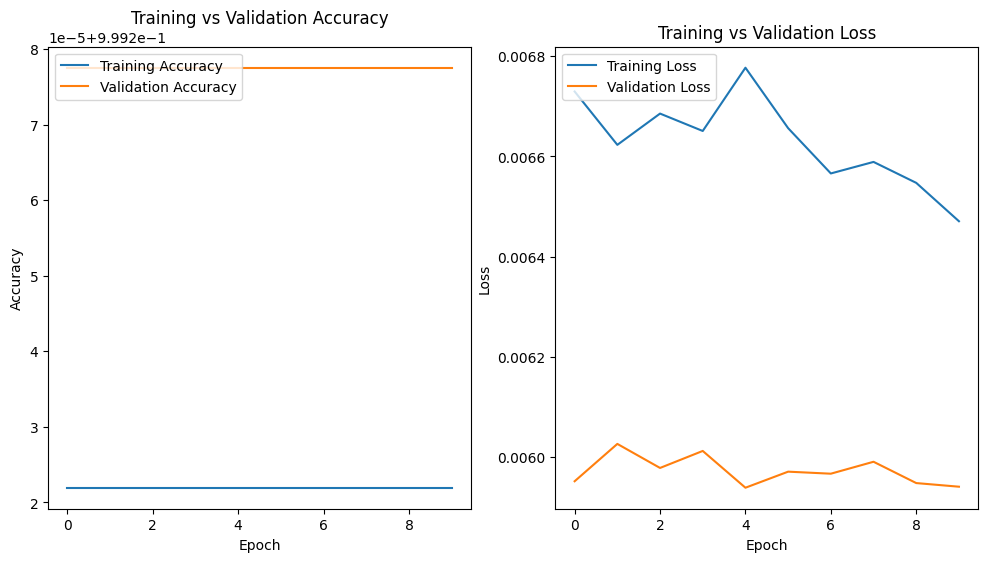

1930/1930 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9976 - loss: 0.0176
Test Loss: 0.017556605860590935
Test Accuracy: 0.9976512789726257


In [10]:
# Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Plot Training History
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training vs Validation Loss')

plt.show()


# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [8]:
# Save the Model

model_json = model.to_json()
with open("human_detection_model.json",'w') as json_file:
    json_file.write(model_json)
model.save("human_detection_model.h5")

print("Model saved to 'human_detection_model.h5'")

Model saved to 'human_detection_model.h5'
